# Определение наиболее выгодного региона нефтедобычи

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Нужно построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализировать возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# План

**1. Загрузка и подготовка данных.**

**2. Обучение и проверка модели.**

**3. Подготовка к расчёту прибыли.**

**4. Расчёт прибыли и рисков.**

**5. Выводы.**

## Загрузка и подготовка данных

### Загрузим данные

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

In [2]:
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
geo_data_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [4]:
geo_data_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [5]:
geo_data_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [6]:
geo_data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [7]:
geo_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [8]:
geo_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Пропусков в данных нет.

### Проверим данные на наличие дубликатов

In [9]:
print(geo_data_0.duplicated().sum())
print(geo_data_1.duplicated().sum())
print(geo_data_2.duplicated().sum())

0
0
0


Явных дубликатов нет.

In [10]:
print(len(geo_data_0['id'].unique()))
print(len(geo_data_1['id'].unique()))
print(len(geo_data_2['id'].unique()))

99990
99996
99996


В 1 первом датасете есть 10 неявных дубликатов, во 2 и 3 по 4. Т.е. несколько скважин встречаются несколько раз. Но таких данных немного, всего 0,1% и 0,04% соответсвенно, значит на результаты они влияния не окажут.

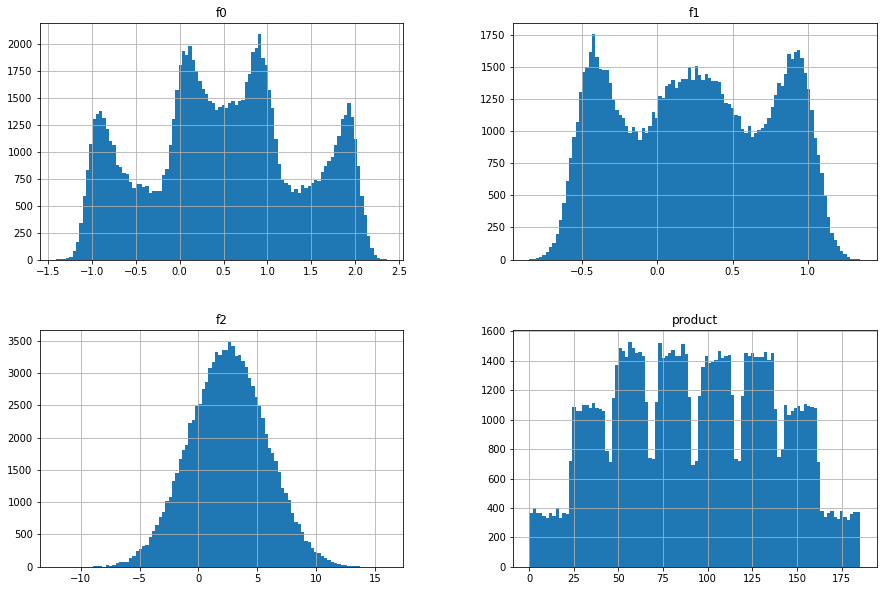

In [11]:
# Построим общую гистограмму для всех числовых столбцов таблицы
geo_data_0.hist(figsize=(15,10), bins=100);

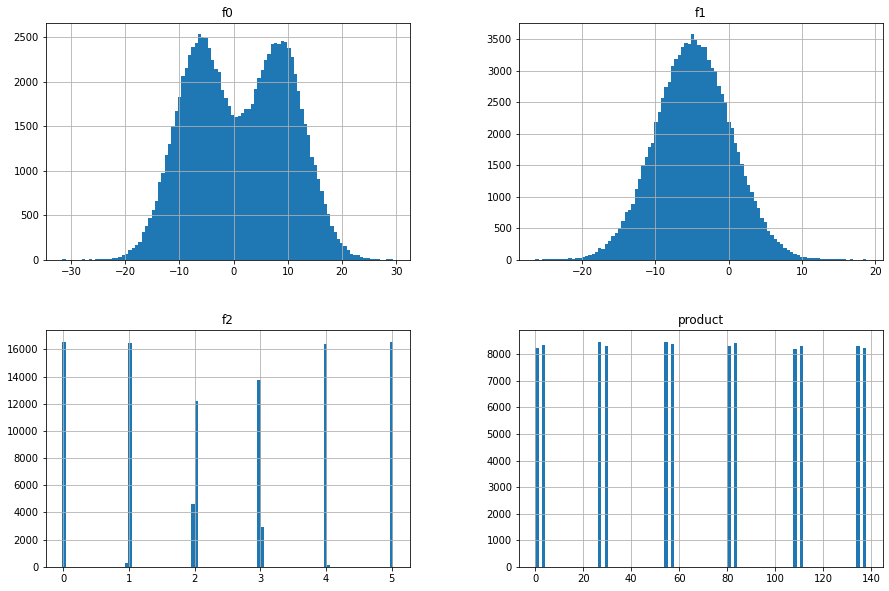

In [12]:
geo_data_1.hist(figsize=(15,10), bins=100);

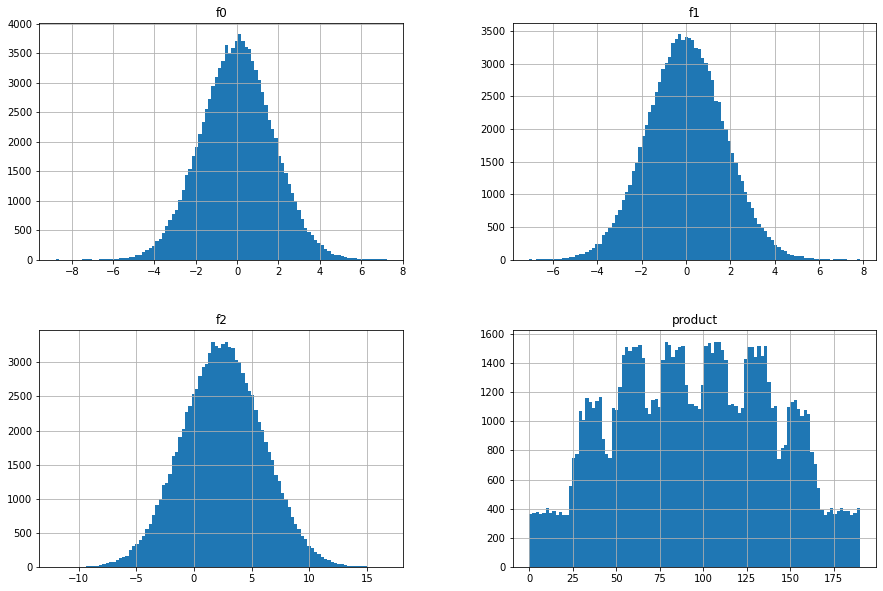

In [13]:
geo_data_2.hist(figsize=(15,10), bins=100);

В каждом датасете данные распределены по-разному: в 3 датасете распределение похоже на нормальное, в 1 датасете распределение тоже похоже на номальное, но есть нкоторые пики, во 2 датасете распределения очень разные, у целевого признака самы распространенные значения - это крайние.

**Промежуточные выводы**

- Прпопусков в данных нет;
- Есть несколько неявных дубликатов, которые не влияют на данные так как их не более 0.1%;
- В каждом датасете данные распределены по-разному.

## Обучение и проверка модели

In [14]:
def model_training (data):
    target = data['product']
    features = data.drop('product', axis=1)
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=12345)
    
    #Масштабируем данные
    scaler = StandardScaler()
    scaler.fit(features_train)
    features_train = pd.DataFrame(scaler.transform(features_train))
    features_valid = pd.DataFrame(scaler.transform(features_valid))
    
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    mse = mean_squared_error(target_valid, predictions_valid)
    rmse = mse ** 0.5
    print('средний запас предсказанного сырья:', predictions_valid.mean())
    print('RMSE:', rmse)
    return predictions_valid.mean(), rmse, pd.Series(predictions_valid, target_valid.index), target_valid, features_valid

In [15]:
clear_geo_data_0 = geo_data_0.drop('id', axis=1)
clear_geo_data_1 = geo_data_1.drop('id', axis=1)
clear_geo_data_2 = geo_data_2.drop('id', axis=1)

In [16]:
mean_0, rmse_0, predictions_valid_0, target_valid_0, features_valid_0 = model_training(clear_geo_data_0)
mean_1, rmse_1, predictions_valid_1, target_valid_1, features_valid_1 = model_training(clear_geo_data_1)
mean_2, rmse_2, predictions_valid_2, target_valid_2, features_valid_2 = model_training(clear_geo_data_2)

средний запас предсказанного сырья: 92.59256778438035
RMSE: 37.5794217150813
средний запас предсказанного сырья: 68.728546895446
RMSE: 0.893099286775617
средний запас предсказанного сырья: 94.96504596800489
RMSE: 40.02970873393434


**Промежуточные выводы**

Итак, наша модель предсказала следующий средний запас сырья в скважине для каждого региона:

1 - 93 тыс. баррелей

2 - 69 тыс. баррелей

3 - 95 тыс. баррелей

RMSE в первом регионе: 37.58

RMSE во втором регионе: 0.89

RMSE во втором регионе: 40.03

В 1 и 3 регионах ошибка получается очень высокой 37.58 и 40.03 тыс. баррелей соответственно. А вот во втором регионе она очень низкая, всего 0.89 тыс. баррелей.

## Подготовка к расчёту прибыли

### Все ключевые значения для расчётов сохраним в отдельных переменных.

In [17]:
BUDGET = 10_000_000_000
UNIT_COST = 450_000
POINTS = 200

### Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. Сравним полученный объём сырья со средним запасом в каждом регионе.

In [18]:
# Т.к. на разработку скважин в регионе выделено 10 млрд. рублей, прибыль должна составить не менее 10 млр. рублей.
# рассчитаем необходимый объем сырья
dot_raw = BUDGET / UNIT_COST / POINTS
print(dot_raw)

111.11111111111111


In [19]:
#Сравним достаточный объем сырья со средним значением в каждом регионе
print(mean_0, mean_1, mean_2)

92.59256778438035 68.728546895446 94.96504596800489


**Промежуточные выводы**

Достаточный объём сырья для безубыточной разработки новой скважины составляет 111 тыс. баррелей.

Наша модель предсказывает среднее кол-во для каждого региона 93, 69 и 95 тыс. баррелей соответсвенно. 1 и 3 регион ближе к нужному показателю, но и значение ошибки у них высокое. Зато у второго региона ошибка предсказания очень низкая.

## Расчёт прибыли и рисков 

### Выберем скважины с максимальными значениями предсказаний. 

In [20]:
raw_200_0 = pd.Series(predictions_valid_0).sort_values(ascending = False)
raw_200_0 = raw_200_0.reset_index(drop=True)
raw_200_0 = raw_200_0.loc[:199]
print(raw_200_0.sum() * UNIT_COST - BUDGET)

3996048877.4651318


In [21]:
raw_200_1 = pd.Series(predictions_valid_1).sort_values(ascending = False)
raw_200_1 = raw_200_1.reset_index(drop=True)
raw_200_1 = raw_200_1.loc[:199]
print(raw_200_1.sum() * UNIT_COST - BUDGET)

2485712051.973543


In [22]:
raw_200_2 = pd.Series(predictions_valid_2).sort_values(ascending = False)
raw_200_2 = raw_200_2.reset_index(drop=True)
raw_200_2 = raw_200_2.loc[:199]
print(raw_200_2.sum() * UNIT_COST - BUDGET)

3321754396.2432575


**Промежуточные выводы**

Получили прибыль в первом регионе 3,9 млн. рублей, во втором регионе - 2.5 млн. рублей, в третьем - 3,3 млн. рублей.

### Просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям. Рассчитаем прибыль для полученного объёма сырья.

In [23]:
def profit(target_valid, predictions_valid):
    predict_sorted = predictions_valid.sort_values(ascending = False)
    target_sorted = target_valid[predict_sorted.index][:200]
    product = target_sorted.sum()
    return product * UNIT_COST - BUDGET

### Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.

In [24]:
def bootstrap(target_valid, predictions_valid):
    state = np.random.RandomState(12345)
    values = []
    for i in range(1000):
        target_500 = target_valid.sample(500, replace=True, random_state=state)
        predict_500 = predictions_valid[target_500.index]
        values.append(profit(target_500, predict_500))
    values = pd.Series(values)
    return values

In [25]:
values_0 = bootstrap(target_valid_0, predictions_valid_0)
print(values_0)

0      5.850890e+08
1      5.363934e+08
2      2.110794e+08
3      2.652803e+08
4      2.719929e+08
           ...     
995    4.740955e+08
996    8.559972e+08
997    7.859948e+08
998    3.542215e+08
999    1.988203e+08
Length: 1000, dtype: float64


In [26]:
values_1 = bootstrap(target_valid_1, predictions_valid_1)
print(values_1)

0      2.993594e+08
1      3.828315e+08
2      3.036512e+08
3      6.581902e+08
4      3.585736e+08
           ...     
995    7.559683e+08
996    7.667289e+08
997    3.585114e+08
998    5.098436e+08
999    1.745243e+08
Length: 1000, dtype: float64


In [27]:
values_2 = bootstrap(target_valid_2, predictions_valid_2)
print(values_2)

0     -9.504418e+07
1      7.282106e+08
2      6.112178e+08
3      5.827541e+08
4      2.501458e+07
           ...     
995    5.668660e+08
996   -1.164806e+07
997    6.455952e+08
998    5.367360e+08
999    1.212702e+08
Length: 1000, dtype: float64


### Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков.

In [28]:
mean_profit_0 = values_0.mean()
lower_0 = values_0.quantile(0.025)
upper_0 = values_0.quantile(0.975)
lesion_0 = values_0[values_0 < 0].count() / 1000
print(mean_profit_0)
print(lower_0, upper_0)
print(lesion_0 * 100)

425938526.91059244
-102090094.83793654 947976353.3583689
6.0


In [29]:
mean_profit_1 = values_1.mean()
lower_1 = values_1.quantile(0.025)
upper_1 = values_1.quantile(0.975)
lesion_1 = values_1[values_1 < 0].count() / 1000
print(mean_profit_1)
print(lower_1, upper_1)
print(lesion_1 * 100)

515222773.4432899
68873225.37050176 931547591.2570494
1.0


In [30]:
mean_profit_2 = values_2.mean()
lower_2 = values_2.quantile(0.025)
upper_2 = values_2.quantile(0.975)
lesion_2 = values_2[values_2 < 0].count() / 1000
print(mean_profit_2)
print(lower_2, upper_2)
print(lesion_2 * 100)

435008362.7827556
-128880547.32978901 969706954.1802661
6.4


## Выводы

В ходе исследования была проделана следующая работа:
1. Мы проверили даннын на пропуски и дубликаты. Обнаружились некоторые дубликаты, но они составляли не более 0.1% и не влияли на данные.
2. Обучили модель линейной регрессии, провели масштабирование данных.
- Средний запас предсказанного сырья в первом регионе составил 92.59 тыс. баррелей. RMSE: 37.58.
- Во втором регионе средний запас предсказанного сырья: 68.73, RMSE: 0.89.
- В третьем регионе средний запас предсказанного сырья: 94.97, RMSE: 40.03.

3. Достаточный объём сырья для безубыточной разработки новой скважины составляет 111.11 тыс. баррелей.
- Наша модель предсказывает прибыль в первом регион 3,9 млн. рублей, во втором регионе - 2.5 млн. рублей, в третьем - 3,3 млн. рублей.

4. Нашли среднюю прибыль, 95%-й доверительный интервал и риск убытков  вкаждом регионе.

   1 регион
- Среднее: 425 938 526.
- Доверительный интервал: (-102 090 095; 947 976 353)
- Риск убытков: 6.0%


   2 регион
- Среднее: 515 222 773
- Доверительный интервал: (68 873 225; 931 547 591)
- Риск убытков: 1.0%


   3 регион
- Среднее: 435 008 363
- Доверительный интервал: (128 880 547; 969 706 954)
- Риск убытков: 6.4%

Мы рекомендуем 2 регион для разработки скважин. Ошибка модели в этом регионе очень низкая: 0.89. Самый высокий средний показатель по технике Bootstrap, безубыточный 95%-й доверительный интервал. Риск убытков 1%.
